# Lab 5: Linear regression

In this lab, you will review the details of linear regression. In particular:

* How to formulate Matrices and solutions to Ordinary Least Squares (OLS).
* `sns.lmplot` as a quick visual for Simple Linear Regression (SLR).
* `scikit-learn`, or `sklearn` for short, a real-world data science tool that is more robust and flexible than analytical or `scipy.optimize` solutions. 

You will also practice interpreting residual plots (vs. fitted values) and the Multiple $R^2$ metric used in Multiple Linear Regression.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set_context("talk")
%matplotlib inline



For the first part of this lab, you will predict fuel efficiency (`mpg`) of several models of automobiles using a **single feature**: engine power (`horsepower`). For the second part, you will perform feature engineering on **multiple features** to better predict fuel efficiency.

First, let's load in the data.

In [2]:
# Here, we load the fuel dataset, and drop any rows that have missing data.
vehicle_data = sns.load_dataset('mpg').dropna()
vehicle_data = vehicle_data.sort_values('horsepower', ascending=True)
vehicle_data.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


In [3]:
vehicle_data.shape

(392, 9)

We have 392 datapoints and 8 potential features (plus our observed $y$ values, `mpg`).

Let's try to fit a line to the plot below, which shows `mpg` vs. `horsepower` for several models of automobiles.

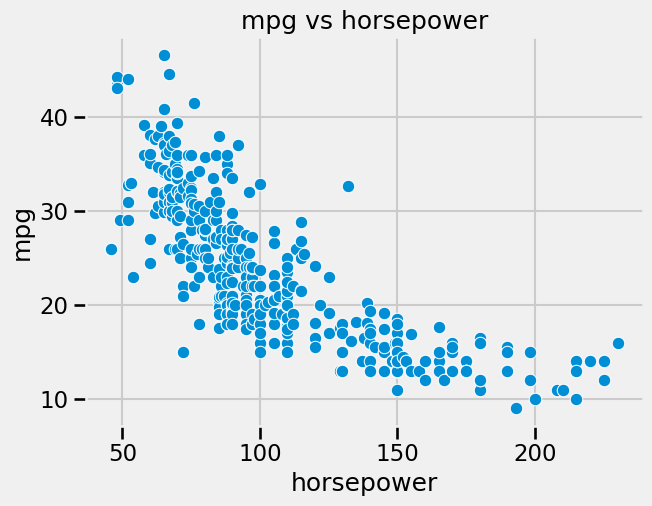

In [4]:
# Run this cell to visualize the data. 
sns.scatterplot(data=vehicle_data, x='horsepower', y='mpg');
plt.title("mpg vs horsepower");



### Question 1a: Construct $\mathbb{X}$ with an intercept term


Below, implement `add_intercept`, which creates a design matrix such that the first (left-most) column is all ones. The function has two lines: you are responsible for constructing the all-ones column `bias_feature` using the `np.ones` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones)). This is then piped into a call to `np.concatenate` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)), which we've implemented for you.

**Note:** `bias_feature` should be a matrix of dimension `(n,1)`, not a vector of dimension `(n,)`.


In [5]:
def add_intercept(X):
    """
    Return X with a bias feature.
    
    Parameters
    -----------
    X: a 2D DataFrame of p numeric features
    (may also be a 2D NumPy array) of shape n x p
    
    Returns
    -----------
    A 2D matrix of shape n x (p + 1), where the leftmost
    column is a column vector of 1's.
    """
    bias_feature = np.ones((X.shape[0], 1))
    return np.concatenate([bias_feature, X], axis=1)

# Note the [[ ]] brackets below: the argument needs to be
# a matrix (DataFrame), as opposed to a single array (Series).
X = add_intercept(vehicle_data[['horsepower']])
X.shape

(392, 2)


### Question 1b: Define the OLS Model

The predictions for all $n$ points in our data are:
$$ \Large \hat{\mathbb{Y}} = \mathbb{X}\theta $$
where $\theta = [\theta_0, \theta_1, \dots, \theta_p]$.

Below, implement the `linear_model` function to evaluate this product.

**Hint**: You can use `np.dot` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)), `pd.DataFrame.dot` ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dot.html)), or the `@` operator to multiply matrices/vectors. However, while the `@` operator can be used to multiply `NumPy` arrays, it generally will not work between two `pandas` objects, so keep that in mind when computing matrix-vector products!

In [6]:
def linear_model(thetas, X):
    """
    Return the linear combination of thetas and features as defined in the OLS equation.
    
    Parameters
    -----------
    thetas: a 1D vector representing the parameters of our model ([theta0, theta1, ...]).
    X: a 2D DataFrame of numeric features (may also be a 2D NumPy array).
    
    Returns
    -----------
    A 1D vector representing the linear combination of thetas and features as defined in the OLS equation.
    """
    return np.dot(X, thetas)



### Question 1c: Least Squares Estimate, Analytically


We showed in lecture that when $X^TX$ is invertible, the optimal estimate, $\hat{\theta}$, is given by the equation:

$$ \Large \hat{\theta} = (\Bbb{X}^T\Bbb{X})^{-1}\Bbb{X}^T\Bbb{Y}$$

Below, implement the analytic solution to $\hat{\theta}$ using `np.linalg.inv` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) to compute the inverse of $\Bbb{X}^T\Bbb{X}$.

**Hint 1**: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T)).

**Note:** You can also consider using `np.linalg.solve` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)) instead of `np.linalg.inv` because it is more robust (more on StackOverflow [here](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li)). 


In [7]:
def get_analytical_sol(X, y):
    """
    Computes the analytical solution to our
    least squares problem
    
    Parameters
    -----------
    X: a 2D DataFrame (or NumPy array) of numeric features.
    y: a 1D vector of outputs.
    
    Returns
    -----------
    The estimate for theta (a 1D vector) computed using the
    equation mentioned above.
    """
    return np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))

Y = vehicle_data['mpg']
analytical_thetas = get_analytical_sol(X, Y)
analytical_thetas

array([39.93586102, -0.15784473])

<br/>

Now, let's analyze our model's performance. Your task will be to interpret the model's performance using the two visualizations and one performance metric we've implemented below.

First, we run `sns.lmplot`, which will both provide a scatterplot of `mpg` vs `horsepower` and display the least-squares line of best fit. (If you'd like to verify the OLS fit you found above is the same line found through `Seaborn`, change `include_OLS` to `True`.)

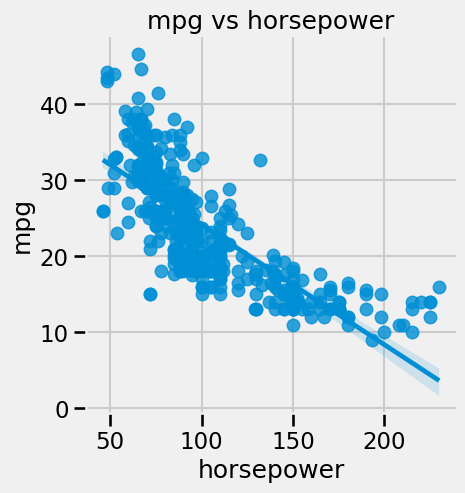

In [8]:
include_OLS = False # Change this flag to visualize OLS fit

sns.lmplot(data=vehicle_data, x='horsepower', y='mpg');
predicted_mpg_hp_only = linear_model(analytical_thetas, X)
if include_OLS:
    # if flag is on, add OLS fit as a dotted red line
    plt.plot(vehicle_data['horsepower'], predicted_mpg_hp_only, 'r--')
plt.title("mpg vs horsepower");

Next, we **plot the residuals.** While in Simple Linear Regression we have the option to plot residuals vs. the single input feature, in Multiple Linear Regression we often plot residuals vs. fitted values $\hat{\mathbb{Y}}$. In this lab, we opt for the latter.

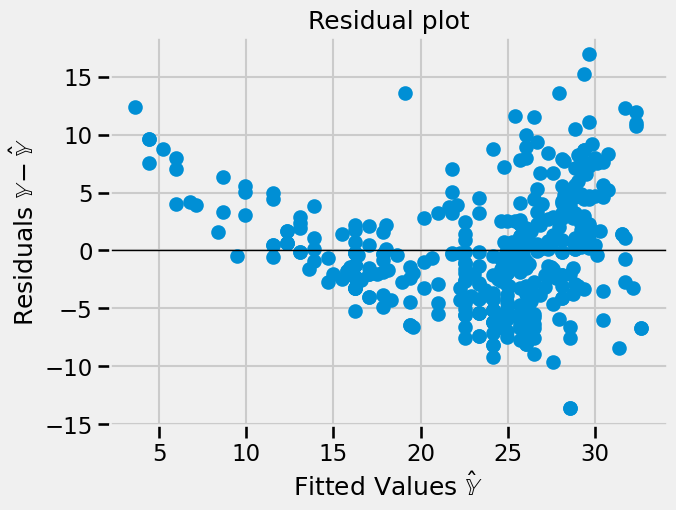

In [9]:
plt.scatter(predicted_mpg_hp_only, Y - predicted_mpg_hp_only)
plt.axhline(0, c='black', linewidth=1)
plt.xlabel(r'Fitted Values $\hat{\mathbb{Y}}$')
plt.ylabel(r'Residuals $\mathbb{Y} - \hat{\mathbb{Y}}$');
plt.title("Residual plot");

Finally, we compute the **correlation r** and **Multiple $R^2$** metric. As described in Lecture 12,

$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

$R^2$  can be used
in the multiple regression setting, whereas $r$ (the correlation coefficient) is restricted to SLR since it depends on a single input feature.  In SLR, $r^{2}$ and Multiple $R^{2}$ are
equivalent; the proof is left to you.

In [10]:
r_hp_only = np.corrcoef(X[:, 1], Y)[0, 1]
r2_hp_only = r_hp_only ** 2
R2_hp_only = np.var(predicted_mpg_hp_only) / np.var(Y)

print('Correlation, r, using only horsepower: ', r_hp_only)
print('Correlation squared, r^2, using only horsepower: ', r2_hp_only)
print('Multiple R^2 using only horsepower: ', r2_hp_only)

Correlation, r, using only horsepower:  -0.7784267838977761
Correlation squared, r^2, using only horsepower:  0.605948257889435
Multiple R^2 using only horsepower:  0.605948257889435


<!-- BEGIN QUESTION -->

<br>

---
### Question 1d

In the cell below, comment on the above visualization and performance metrics, and whether `horsepower` and `mpg` have a good linear fit.


From the above graph, we can see that the distribution of the data seem to be a
exponential distribution. We can affirm our claim from the residual plot, where
it does not seem like that residuals are centered around $y=0$.

<!-- END QUESTION -->


## Question 2: Transform a Single Feature

The Tukey-Mosteller Bulge Diagram (shown below) tells us to transform our $\mathbb{X}$ or $\mathbb{Y}$ to find a linear fit.

<div style="text-align:center"><img src="tukey_mosteller.png" width="300vw" /></div>

Let's consider the following linear model:

$$\text{predicted mpg} = \theta_0 + \theta_1 \sqrt{\text{horsepower}}$$

<!-- BEGIN QUESTION -->

<br>

---
### Question 2a

In the cell below, explain why we use the term "linear" to describe the model above, even though it incorporates a square root of horsepower  as a feature.


This simply a multiple linear regression model with $X = \sqrt{horsepower}$. So we can use standard linear regression software to estimate $\theta_0, \theta_1$ in order to produce a non-linear ﬁt.

<!-- END QUESTION -->

### Introduction to `sklearn`



##### **1. Create object.** 

We first create a `LinearRegression` object. Here's the `sklearn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Note that by default, the object will include an intercept term when fitting.

Here, `model` is like a "blank slate" for a linear model.

In [11]:
# 1. Run this cell to initialize a sklearn LinearRegression object.
from sklearn.linear_model import LinearRegression

# the `fit_intercept` argument controls whether or not the model should have an intercept (or bias) term
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

##### **2. `fit` the object to data.** 

Now, we need to tell `model` to "fit" itself to the data. Essentially, this is doing exactly what you did in the previous part of this lab (creating a risk function and finding the parameters that minimize that risk).

**Note**: `X` needs to be a matrix (or `DataFrame`), as opposed to a single array (or `Series`) when running `model.fit`. This is because `sklearn.linear_model` is robust enough to be used for multiple regression, which we will look at later in this lab. This is why we use the double square brackets around `sqrt(hp)` when passing in the argument for `X`.

In [12]:
# 2. Run this cell to add sqrt(hp) column for each car in the dataset.
vehicle_data['sqrt(hp)'] = np.sqrt(vehicle_data['horsepower'])
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp)
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203


In [13]:
# 2. Run this cell to fit the model to the data.
model.fit(X = vehicle_data[['sqrt(hp)']], y = vehicle_data['mpg'])

LinearRegression()

##### **3. Analyze fit.** 

Now that the model exists, we can look at the $\hat{\theta}_0$ and $\hat{\theta}_1$ values it found, which are given in the attributes `intercept` and `coef`, respectively.

In [14]:
model.intercept_

58.70517203721754

In [15]:
model.coef_

array([-3.50352375])

To use the `sklearn` linear regression model to make predictions, you can use the `model.predict` method.

Below, we find the estimated `mpg` for a single datapoint with a `sqrt(hp)` of 6.78 (i.e., horsepower 46). Unlike the linear algebra approach, we do not need to manually add an intercept term because our `model` (which was created with `fit_intercept=True`) will automatically add one.

**Note:** You may receive a user warning about missing feature names. This is due to the fact that we fitted on the feature DataFrame `vehicle_data[['sqrt(hp)']]` with feature names `"sqrt(hp)"` but only pass in a simple 2D arrays for prediction. To avoid this, we can convert our 2D array into a DataFrame with the matching feature name.

In [16]:
# Needs to be a 2D array since the X in step 2 was 2-dimensional.
single_datapoint = [[6.78]]
# Uncomment the following to see the result of predicting on a DataFrame instead of 2D array.
#single_datapoint = pd.DataFrame([[6.78]], columns = ['sqrt(hp)']) # 
model.predict(single_datapoint) 

/Users/ngtzekean/Github/STAT4710J-Data-Science-and-Analytics-using-Python/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([34.95128104])

<!-- BEGIN QUESTION -->

<br>

---

### Question 2b

Using the model defined above, which takes in `sqrt(hp)` as an input explanatory variable, predict the `mpg` for the full `vehicle_data` dataset. Assign the predictions to `predicted_mpg_hp_sqrt`. Running the cell will then compute the multiple $R^2$ value and create a linear regression plot for this new square root feature, overlaid on the original least squares estimate (used in Question 1c).

Multiple R^2 using sqrt(hp):  0.6437035832706492


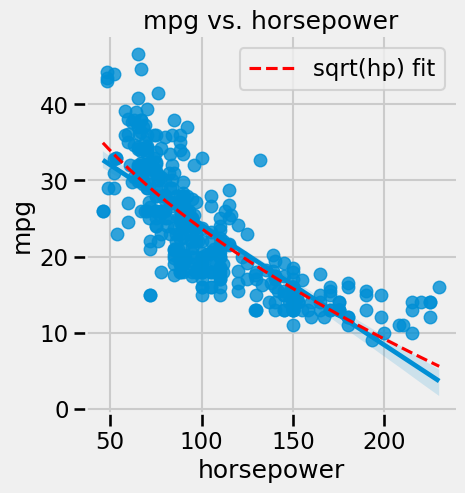

In [17]:
predicted_mpg_hp_sqrt = model.predict(vehicle_data[['sqrt(hp)']])

# Do not modify below this line.
r2_hp_sqrt = np.var(predicted_mpg_hp_sqrt) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)

sns.lmplot(x = 'horsepower', y = 'mpg', data = vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt,
         color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.title("mpg vs. horsepower")
plt.legend();

<!-- END QUESTION -->

The visualization shows a slight improvement, but the points on the scatter plot are still more "curved" than our prediction line. Let's try a quadratic feature instead! 

Next, we use the power of OLS to **add an additional feature.** Questions 1 and 2 utilized simple linear regression, a special case of OLS where we have 1 feature ($p=1$). For the following questions, we'll utilize multiple linear regression, which are cases of OLS when we have more than 1 features ($p > 1$). 

<br/>
<hr style="border: 1px solid #fdb515;" />

## Add an Additional Feature

Now, we move from SLR to multiple linear regression.

Until now, we have established relationships between one independent explanatory variable and one response variable. However, with real-world problems, you will often want to use **multiple features** to model and predict a response variable. Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to the observed data.

We can consider including functions of existing features as **new features** to help improve the predictive power of our model. (This is something we will discuss in further detail in the Feature Engineering lecture.)

The cell below adds a column that contains the square of the horsepower for each car in the dataset.

In [18]:
# Run this cell to add a column of horsepower squared, no further action needed.
vehicle_data['hp^2'] = vehicle_data['horsepower'] ** 2
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp),hp^2
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330,2116.0
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330,2116.0
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203,2304.0
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203,2304.0
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203,2304.0



## Question 3

### Question 3a

Using `sklearn`'s `LinearRegression`, create and fit a model that tries to predict `mpg` from `horsepower` AND `hp^2` using the DataFrame `vehicle_data`. Name your model `model_multi`.

**Hint**: It should follow a similar format as Question 2.

**Note**: You must create a new model again using `LinearRegression()`, otherwise the old model from Question 2 will be overwritten. If you do overwrite it,just restart your kernel and run your cells in order. 

In [19]:
model_multi = LinearRegression() # By default, fit_intercept=True
model_multi.fit(X = vehicle_data[['horsepower', 'hp^2']], y = vehicle_data['mpg'])

LinearRegression()

After fitting, we can see the coefficients and intercept. Note that there are now two elements in `model_multi.coef_`, since there are two features.

In [20]:
model_multi.intercept_

56.90009970211304

In [21]:
model_multi.coef_

array([-0.46618963,  0.00123054])



### Question 3b

Using the above values, write out the function that the model is using to predict `mpg` from `horsepower` and `hp^2`.


$mpg = \theta_0 + \theta_1 \times horsepower + \theta_2 \times horsepower^2$

The above equation sets how we will use the variables to predict `mpg`

<!-- END QUESTION -->

<br/>

The plot below shows the prediction of our model. It's much better!

Multiple R^2 using both horsepower and horsepower squared:  0.6875590305127552


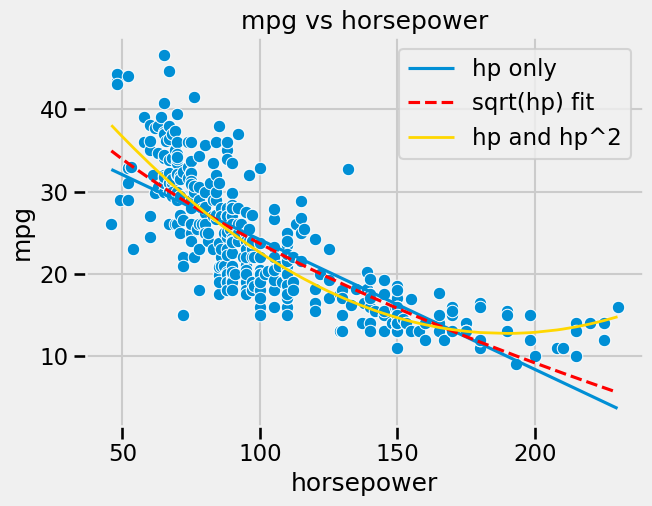

In [22]:
# Run this cell to show the prediction of our model.
predicted_mpg_multi = model_multi.predict(vehicle_data[['horsepower', 'hp^2']])
r2_multi = np.var(predicted_mpg_multi) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using both horsepower and horsepower squared: ', r2_multi)

sns.scatterplot(x = 'horsepower', y = 'mpg', data = vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_only, label='hp only');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt, color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_multi, color = 'gold', linewidth=2, label='hp and hp^2');
plt.title("mpg vs horsepower")
plt.legend();

By incorporating a squared feature, we are able to capture the curvature of the dataset. Our model is now a parabola centered on our data. 

<br>

---

### Question 3c

In the cell below, we assign the mean of the `mpg` column of the `vehicle_data` DataFrame to `mean_mpg`. Given this information, what is the mean of the `mean_predicted_mpg_hp_only`, `predicted_mpg_hp_sqrt`, and `predicted_mpg_multi` arrays?

**Hint**: Your answer should be a function of `mean_mpg` provided, you should not have to call `np.mean` in your code.


In [23]:
model.coef_

array([-3.50352375])

In [24]:
mean_mpg = np.mean(vehicle_data['mpg'])
mean_predicted_mpg_hp_only = mean_mpg 
mean_predicted_mpg_hp_sqrt = np.mean(predicted_mpg_hp_sqrt)
mean_predicted_mpg_multi = np.mean(predicted_mpg_multi)

Comparing this model with previous models:

In [25]:
# Compares q1, q2, q3, and overfit models (ignores redundant model)
print('Multiple R^2 using only horsepower: ', r2_hp_only)
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)
print('Multiple R^2 using both hp and hp^2: ', r2_multi)

Multiple R^2 using only horsepower:  0.605948257889435
Multiple R^2 using sqrt(hp):  0.6437035832706492
Multiple R^2 using both hp and hp^2:  0.6875590305127552


Observe that the R^2 value of the last model is the highest. In fact, it can be proven that multiple R^2 will not decrease as we add more variables. You may be wondering, what will happen if we add more variables? We will discuss the limitations of adding too many variables in an upcoming lecture. Below, we consider an extreme case that we include a variable twice in the model.

You might also be wondering why we chose to use `hp^2` as our additional feature, even though that transformation in the Tukey-Mosteller Bulge Diagram doesn't correspond to the bulge in our data. The Bulge diagram is a good starting point for transforming our data, but you may need to play around with different transformations to see which of them is able to capture the true relationship in our data and create a model with the best fit. This trial and error process is a very useful technique used all throughout data science!

<br/>
<hr style="border: 1px solid #fdb515;" />

## Faulty Feature Engineering: Redundant Features

Suppose we used the following linear model:

\begin{align}
\text{mpg} &= \theta_0 + \theta_1 \cdot \text{horsepower} + \theta_2 \cdot \text{horsepower}^2 + \theta_3 \cdot \text{horsepower}
\end{align}

Notice that `horsepower` appears twice in our model!! We will explore how this redundant feature affects our modeling.

<br>

---

## Question 4

### Question 4a: Linear Algebra

Construct a matrix `X_redundant` that uses the `vehicle_data` DataFrame to encode the "three" features above, as well as a bias feature.

**Hint**: Use the `add_intercept` term you implemented in Question 1a.


In [26]:
X_redundant = add_intercept(vehicle_data[['horsepower', 'hp^2','horsepower']])
X_redundant.shape

(392, 4)

<br>

Now, run the cell below to find the analytical OLS Estimate using the `get_analytical_sol` function you wrote in Question 1c.

**Note:** Depending on the machine that you run your code on, you should either **see a singular matrix error** or **end up with thetas that are nonsensical** (magnitudes greater than $10^{15}$). In other words, if the cell below errors, that is by design, it is supposed to error. 

In [27]:
X_redundant

array([[1.0000e+00, 4.6000e+01, 2.1160e+03, 4.6000e+01],
       [1.0000e+00, 4.6000e+01, 2.1160e+03, 4.6000e+01],
       [1.0000e+00, 4.8000e+01, 2.3040e+03, 4.8000e+01],
       ...,
       [1.0000e+00, 2.2500e+02, 5.0625e+04, 2.2500e+02],
       [1.0000e+00, 2.2500e+02, 5.0625e+04, 2.2500e+02],
       [1.0000e+00, 2.3000e+02, 5.2900e+04, 2.3000e+02]])

In [28]:
# Run this cell to check the result, no further action needed. 
# The try-except block suppresses errors during submission
import traceback
try:
    analytical_thetas = get_analytical_sol(X_redundant, vehicle_data['mpg'])
    print(analytical_thetas)
except Exception as e:
    print(traceback.format_exc())

[ 5.69000997e+01 -3.22185942e-01  1.23053610e-03 -1.44003688e-01]


In [29]:
import traceback
try:
    np.linalg.det(X_redundant)
except Exception as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/var/folders/_m/glx_2hfd76x1hdgjm__cz8mw0000gn/T/ipykernel_35603/3549820896.py", line 3, in <module>
    np.linalg.det(X_redundant)
  File "/Users/ngtzekean/Github/STAT4710J-Data-Science-and-Analytics-using-Python/venv/lib/python3.12/site-packages/numpy/linalg/linalg.py", line 2177, in det
    _assert_stacked_square(a)
  File "/Users/ngtzekean/Github/STAT4710J-Data-Science-and-Analytics-using-Python/venv/lib/python3.12/site-packages/numpy/linalg/linalg.py", line 213, in _assert_stacked_square
    raise LinAlgError('Last 2 dimensions of the array must be square')
numpy.linalg.LinAlgError: Last 2 dimensions of the array must be square



<!-- BEGIN QUESTION -->

---

### Question 4b

In the cell below, explain why we got the error above when trying to calculate the analytical solution to predict `mpg`.


The columns of the design matrix are no longer linearly independent since there
exist 2 columns with the same predictor. That is one of the column is dependent
on another column. This causes the matrix to no longer be invertible by definition.

Based on the equation used to solve for theta above, we require $X$ to be invertible,
thus calling `get_analytical_sol` will throw an error. However, I suspect that
my machine does not throw an error due to how the computation is done.
Trying to get the determinant of the matrix throws our expected error. `np.linalg.det(X_redundant)`

<!-- END QUESTION -->

Note: While we encountered errors when using the linear algebra approach, a model fitted with `sklearn` will not encounter matrix singularity errors since it uses numerical methods to find optimums .

In [30]:
# sklearn finds optimal parameters despite redundant features
model_redundant = LinearRegression(fit_intercept=False) # X_redundant already has an intercept column
model_redundant.fit(X = X_redundant, y = vehicle_data['mpg'])
model_redundant.coef_

array([ 5.69000997e+01, -2.33094815e-01,  1.23053610e-03, -2.33094815e-01])

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

To begin, let's load the tips dataset from the `seaborn` library.  This dataset contains records of tips, total bill, and information about the person who paid the bill. As earlier, we'll be trying to predict tips from the other data.

In [31]:
# Run this cell to load the tips dataset; no further action is needed.
data = sns.load_dataset("tips")

print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


<br/>
<hr style="border: 1px solid #fdb515;" />

## Defining the Model and Engineering Features

 Now, let's make a more complicated model that utilizes other features in our dataset. You can imagine that we might want to use the features with an equation that looks as shown below:

$$ \text{Tip} = \theta_0 + \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{sex} + \theta_3 \cdot \text{smoker} + \theta_4 \cdot \text{day} + \theta_5 \cdot \text{time} + \theta_6 \cdot \text{size} $$

Unfortunately, that's not possible because some of these features like "day" are not numbers, so it doesn't make sense to multiply by a numerical parameter. Let's start by converting some of these non-numerical values into numerical values.

Before we do this, let's separate out the tips and the features into two separate variables, and add a bias term using `pd.insert` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.insert.html)).

In [32]:
# Run this cell to create our design matrix X; no further action is needed.
tips = data['tip']
X = data.drop(columns='tip')
X.insert(0, 'bias', 1)
X.head()

,bias,total_bill,sex,smoker,day,time,size
0,1,16.99,Female,No,Sun,Dinner,2
1,1,10.34,Male,No,Sun,Dinner,3
2,1,21.01,Male,No,Sun,Dinner,3
3,1,23.68,Male,No,Sun,Dinner,2
4,1,24.59,Female,No,Sun,Dinner,4




## Question 5: Feature Engineering

Let's use **one-hot encoding** to better represent the days! For example, we encode Sunday as the row vector `[0 0 0 1]` because our dataset only contains bills from Thursday through Sunday. This replaces the `day` feature with four boolean features indicating if the record occurred on Thursday, Friday, Saturday, or Sunday. One-hot encoding therefore assigns a more even weight across each category in non-numeric features.

Complete the code below to one-hot encode our dataset. This `DataFrame` holds our "featurized" data, which is also often denoted by $\phi$.


In [33]:
def one_hot_encode(data):
    """
    Return the one-hot encoded DataFrame of our input data.
    
    Parameters
    -----------
    data: A DataFrame that may include non-numerical features.
    
    Returns
    -----------
    A one-hot encoded DataFrame that only contains numeric features.
    
    """
    ohe = OneHotEncoder()
    data.select_dtypes(exclude='number')
    transformed = ohe.fit_transform(data.select_dtypes(exclude='number')).toarray()
    data = pd.concat([data.select_dtypes(include='number'),
                      pd.DataFrame(transformed, columns=ohe.get_feature_names_out())]
                     ,ignore_index=False,axis=1)
    return data

    
one_hot_X = one_hot_encode(X)
one_hot_X.head()

,bias,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,1,16.99,2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,10.34,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,21.01,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,23.68,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1,24.59,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


<br>

### Tutorial: fit()/predict()

Now that all of our data is numeric, we can begin to define our model function. Notice that after one-hot encoding our data, we now have 13 features instead of 7 (including bias). Therefore, our linear model is now similar to the below (note the order of thetas below does not necessarily match the order in the `DataFrame`):

\begin{align}
\text{Tip} &= \theta_0 + \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{size}  \\
& + \theta_3 \cdot \text{sex}\_\text{Female} + \theta_4 \cdot \text{sex}\_\text{Male} \\
& + \theta_5 \cdot \text{smoker}\_\text{No} + \theta_{6} \cdot \text{smoker}\_\text{Yes} \\
& + \theta_7 \cdot \text{day}\_\text{Fri} + \theta_8 \cdot \text{day}\_\text{Sat} + \theta_9 \cdot \text{day}\_\text{Sun} + \theta_{10} \cdot \text{day}\_\text{Thur} \\
& + \theta_{11} \cdot \text{time}\_\text{Dinner}+ \theta_{12} \cdot \text{time}\_\text{Lunch} 
\end{align}

We can represent the linear combination above as a matrix-vector product. To practice using syntax similar to the `sklearn` pipeline, we introduce a toy example called `MyZeroLinearModel`.

The `MyZeroLinearModel` has two methods, `predict` and `fit`.
* `fit`: Compute parameters theta given data `X` and `Y` and the underlying model.
* `predict`: Compute estimate $\hat{y}$ given `X` and the underlying model.

If you are unfamiliar with using `Python` objects, please review object-oriented programming. 

**Note:** Practically speaking, this is a pretty bad model: it sets all of its parameters to 0 regardless of the data we fit it to! While this model doesn't really have any practical application, we're using it here to help you build intuition on how `sklearn` pipelines work! 

In [34]:
# Run this cell to create the MyZeroLinearModel class; no further action is needed.
class MyZeroLinearModel():
    def __init__(self):
        self._thetas = None
    def fit(self, X, Y):
        number_of_features = X.shape[1]
        # For demonstration purposes in this tutorial, we set the values of all the parameters to 0. 
        self._thetas = np.zeros(shape=(number_of_features, 1))
    
    def predict(self, X):
        return X @ self._thetas

# Running the code below produces all-zero thetas
model0 = MyZeroLinearModel()
model0.fit(one_hot_X, tips)
model0._thetas

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])



## Question 6: Fitting a Linear Model Using Numerical Methods


The best-fit model is determined by our loss function.  We can define multiple loss functions and found the optimal $\hat{\theta}$ using the `scipy.optimize.minimize` function. 


In this question, we'll wrap this function into a method `fit()` in our class `MyScipyLinearModel`.
To allow for different loss functions, we create a `loss_function` parameter where the model can be fit accordingly. Example loss functions are given as `l1` and `l2`.

**Note:** Just like `MyZeroLinearModel`, the class `MyScipyLinearModel` is a toy example to help you understand how `sklearn` works behind the scenes. In practice, when using pre-made `sklearn` models, defining a class like this is unnecessary!

---

### Question 6a: scipy

Complete the code below using `scipy.optimize.minimize`. Find and store the optimal $\hat{\theta}$ in the instance attribute `self._thetas`.

**Hint:**
* The `starting_guess` should be some arbitrary array (such as an array of all zeroes) of the correct length. You may find `number_of_features` helpful.

**Notes:**
* Notice that `l1` and `l2` return term-wise loss and only accept observed value $y$ and predicted value $\hat{y}$. We added a lambda function to help convert them into the right format for `scipy.optimize.minimize`.
* Notice above that we extract the `'x'` entry in the dictionary returned by `minimize`. This entry corresponds to the optimal $\hat{\theta}$ estimated by the function, and it is the format that `minimize` uses.

In [35]:
from scipy.optimize import minimize

def l1(y, y_hat):
    return np.abs(y - y_hat)

def l2(y, y_hat):
    return (y - y_hat)**2

class MyScipyLinearModel():
    def __init__(self):
        self._thetas = None
        
    def fit(self, loss_function, X, Y):
        """
        Estimated optimal _thetas for the given loss function, 
        feature matrix X, and observed values y. Store them in _thetas.

        Parameters
        -----------
        loss_function: A function that takes in observed and predicted y, 
                       and return the loss calculated for each data point.
        X: A 2D DataFrame (or NumPy array) of numeric features.
        Y: A 1D NumPy array or Series of the dependent variable.

        Returns
        -----------
        None
        """
        
        number_of_features = X.shape[1]
        starting_guess = np.zeros(number_of_features)
        self._thetas = minimize(lambda theta:
                                np.mean(loss_function(Y, X @ theta))
                                ,x0 = starting_guess)['x']        
        
    def predict(self, X):
        return X @ self._thetas
        
# Create a new model and fit the data using l2 loss, it should produce some non-zero thetas.
model = MyScipyLinearModel()
model.fit(l2, one_hot_X, tips)
print("L2 loss thetas:")
print(model._thetas)

# Create a new model and fit the data using l1 loss, it should produce some non-zero thetas.
model_l1 = MyScipyLinearModel()
model_l1.fit(l1, one_hot_X, tips)
print("L1 loss thetas:")
print(model._thetas)

L2 loss thetas:
[ 0.25497699  0.09448757  0.17597879  0.14370704  0.11127025  0.17070342
  0.08427349  0.14102196  0.01962846  0.11559517 -0.02126848  0.09338208
  0.16159492]
L1 loss thetas:
[ 0.25497699  0.09448757  0.17597879  0.14370704  0.11127025  0.17070342
  0.08427349  0.14102196  0.01962846  0.11559517 -0.02126848  0.09338208
  0.16159492]


The MSE and MAE for your model above should be just slightly larger than 1:

In [36]:
# Run this cell to calculate the MSE and MAE of the above model; no further action is needed.
from sklearn.metrics import mean_squared_error
print("L2 loss MSE scipy: " + str(mean_squared_error(model.predict(one_hot_X), tips)))
print("L1 loss MAE scipy: " + str(mean_squared_error(model_l1.predict(one_hot_X), tips)))

L2 loss MSE scipy: 1.0103535616280632
L1 loss MAE scipy: 1.0369253117700548




### Question 6b: sklearn

Another way to fit a linear regression model is to use `scikit-learn`/`sklearn` 

In [37]:
from sklearn.linear_model import LinearRegression

sklearn_model = LinearRegression()
sklearn_model.fit(one_hot_X,tips)
print("sklearn with bias column thetas:")
print(sklearn_model.coef_)

sklearn with bias column thetas:
[ 0.          0.09448701  0.175992    0.01622047 -0.01622047  0.04320416
 -0.04320416  0.07729956 -0.04415882  0.0518189  -0.08495964 -0.0340643
  0.0340643 ]


<br>
 
---
 
### Question 6c: sklearn and `fit_intercept`

To avoid always explicitly building in a bias column into our design matrix, `sklearn`'s `LinearRegression` object also supports `fit_intercept=True` during instantiation. 

Fill in the code below by first assigning `one_hot_X_nobias` to the `one_hot_X` design matrix with the bias column dropped, then fit a new `LinearRegression` model, with intercept.

In [38]:
one_hot_X_nobias = one_hot_X.drop(columns='bias')

sklearn_model_intercept = LinearRegression(fit_intercept=True)
sklearn_model_intercept.fit(one_hot_X_nobias, tips)

# Note that sklearn returns intercept (theta_0) and coefficients (other thetas) separately.
# We concatenate the intercept and other thetas before printing for easier comparison with the models above.
print("sklearn with intercept thetas:")
print(np.concatenate(([sklearn_model_intercept.intercept_], sklearn_model_intercept.coef_)))

sklearn with intercept thetas:
[ 0.70115739  0.09448701  0.175992    0.01622047 -0.01622047  0.04320416
 -0.04320416  0.07729956 -0.04415882  0.0518189  -0.08495964 -0.0340643
  0.0340643 ]




## Question 7: Fitting the Model Using Analytic Methods

Let's also fit our model analytically for the L2 loss function. Recall from lecture that with a linear model, we are solving the following optimization problem for least squares:

$$\min_{\theta} \frac{1}{n}||\Bbb{Y} - \Bbb{X}\theta||^2$$

We showed in lecture that the optimal $\hat{\theta}$ when $\Bbb{X}^T\Bbb{X}$ is invertible is given by the equation: $(\Bbb{X}^T\Bbb{X})^{-1}\Bbb{X}^T\Bbb{Y}$

<br>

---
### Question 7a: Analytic Solution Using Explicit Inverses

For this problem, implement the analytic solution above using `np.linalg.inv` to compute the inverse of $\Bbb{X}^T\Bbb{X}$. We provide a class `MyAnalyticallyFitOLSModel` with a `fit` method to wrap this functionality.

**Hint**: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()`.

**Note**: We want our thetas to always be a `NumPy array` object, even if `Y` is a `Series`. If you are using the `@` `NumPy` operator, make sure you are correctly placing parentheses around expressions where needed to make this happen.

In [39]:
class MyAnalyticallyFitOLSModel():
    def __init__(self):
        self._thetas = None
        
    def fit(self, X, Y):
        """
        Sets _thetas using the analytical solution to the OLS problem.

        Parameters
        -----------
        X: A 2D DataFrame (or NumPy array) of numeric features (one-hot encoded).
        Y: A 1D NumPy array or Series of the dependent variable.
        
        Returns
        -----------
        None
        """
        self._thetas = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))
    
    def predict(self, X):
        return X @ self._thetas        

Now, run the cell below to find the analytical solution for the `tips` dataset. Depending on the machine that you run your code on, **you should either see a singular matrix error or end up with some theta values that are nonsensical (magnitudes greater than $10^{15}$).** This is not good!

In [40]:
# Run this cell to check the result, no further action needed.
# The try-except block suppresses errors during submission
import traceback
try:
    model_analytical = MyAnalyticallyFitOLSModel()
    model_analytical.fit(one_hot_X, tips)
    analytical_thetas = model_analytical._thetas
    print(analytical_thetas)
except Exception as e:
    print(traceback.format_exc())

[ -9.85840622   0.09448701   0.175992    22.27415452  22.24171358
  40.28537034  40.19896202 -39.01820511 -39.13966349 -39.04368577
 -39.18046431 -12.87909624 -12.81096764]


In [41]:
import traceback
try:
    np.linalg.det(one_hot_X)
except Exception as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "/var/folders/_m/glx_2hfd76x1hdgjm__cz8mw0000gn/T/ipykernel_35603/4043525803.py", line 3, in <module>
    np.linalg.det(one_hot_X)
  File "/Users/ngtzekean/Github/STAT4710J-Data-Science-and-Analytics-using-Python/venv/lib/python3.12/site-packages/numpy/linalg/linalg.py", line 2177, in det
    _assert_stacked_square(a)
  File "/Users/ngtzekean/Github/STAT4710J-Data-Science-and-Analytics-using-Python/venv/lib/python3.12/site-packages/numpy/linalg/linalg.py", line 213, in _assert_stacked_square
    raise LinAlgError('Last 2 dimensions of the array must be square')
numpy.linalg.LinAlgError: Last 2 dimensions of the array must be square



<!-- BEGIN QUESTION -->

<br>

---

### Question 7b

In the cell below, explain why we got the error or nonsensical theta values above when trying to calculate the analytical solution for our one-hot encoded `tips` dataset.


We fell into the Dummy variable trap whereby there are variables that suffer from
perfect multicolinearity. This causes the column matrix to no longer be linearly
independent. Since the matrix is not full rank, it cannot be inverted. Thus, causing
the equation to be unsolvable.

<!-- END QUESTION -->

<br>

---
### Question 7c: Fixing Our One-Hot Encoding

Now, let's modify our one-hot encoding approach from earlier so we don't get the error we saw in the previous part. Complete the code below to one-hot-encode our dataset such that `one_hot_X_revised` has no redundant features. 

**Hint**: To identify redundancies in one-hot-encoded features, consider the number of boolean values that are required to uniquely express each possible option. For example, we only need one column to express whether an individual it's Lunch or Dinner time: If the value is 0 in the Lunch column, it tells us it must be Dinner time.



In [42]:
def one_hot_encode_revised(data):
    """
    Return the one-hot encoded DataFrame of our input data, removing redundancies.
    
    Parameters
    -----------
    data: A DataFrame that may include non-numerical features.
    
    Returns
    -----------
    A one-hot encoded DataFrame that only contains numeric features without any redundancies.
    
    """
    data = one_hot_encode(X).drop(columns=['sex_Female','smoker_No','time_Lunch','day_Thur'])
    return data

one_hot_X_revised = one_hot_encode_revised(X)
display(one_hot_X_revised.head())
    
scipy_model = MyScipyLinearModel()
scipy_model.fit(l2, one_hot_X_revised, tips)
    
analytical_model = MyAnalyticallyFitOLSModel()
analytical_model.fit(one_hot_X_revised, tips)

print("Our scipy numerical model's loss is: ", mean_squared_error(scipy_model.predict(one_hot_X_revised), tips))
print("Our analytical model's loss is: ", mean_squared_error(analytical_model.predict(one_hot_X_revised), tips))

,bias,total_bill,size,sex_Male,smoker_Yes,day_Fri,day_Sat,day_Sun,time_Dinner
0,1,16.99,2,0.0,0.0,0.0,0.0,1.0,1.0
1,1,10.34,3,1.0,0.0,0.0,0.0,1.0,1.0
2,1,21.01,3,1.0,0.0,0.0,0.0,1.0,1.0
3,1,23.68,2,1.0,0.0,0.0,0.0,1.0,1.0
4,1,24.59,4,0.0,0.0,0.0,0.0,1.0,1.0


Our scipy numerical model's loss is:  1.0103535612444035
Our analytical model's loss is:  1.0103535612257852


We can check the rank of the matrix using the `NumPy` function `np.linalg.matrix_rank`. We have printed the rank of the data and number of columns for you below. 

In [43]:
print("one_hot_X: \n"
      + "\t number of columns: " + str(len(one_hot_X.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_X)))
print("one_hot_X_revised: \n"
      + "\t number of columns: " + str(len(one_hot_X_revised.columns)) \
      + "\trank: " + str(np.linalg.matrix_rank(one_hot_X_revised)))

one_hot_X: 
	 number of columns: 13	rank: 9
one_hot_X_revised: 
	 number of columns: 9	rank: 9
